Run this notebook to convert the Animals dataset to YOLO format. [Original code](https://www.kaggle.com/code/yourwanghao/learn-yolov5-on-animal-datasets/notebook).

In [13]:
!pip install --upgrade pip
!pip install opencv-python-headless

import numpy as np
import pandas as pd
import glob
from tqdm import tqdm
import os
import cv2
import matplotlib.pyplot as plt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.7/55.7 MB 11.0 MB/s eta 0:00:0000:0100:01


In [14]:
!pip install opendatasets --upgrade
import opendatasets as od
import pandas

od.download("https://www.kaggle.com/datasets/antoreepjana/animals-detection-images-dataset/")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:Your Kaggle username:Your Kaggle Key:Downloading animals-detection-images-dataset.zip to ./animals-detection-images-dataset


100%|██████████| 8.92G/8.92G [11:43<00:00, 13.6MB/s]


In [17]:
data_dir= "/Users/dialvare/Desktop/animals-detection-images-dataset"
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")

all_train_subdir=glob.glob(train_dir+"/*")
all_test_subdir=glob.glob(test_dir+"/*")

train_classes=[os.path.basename(pp) for pp in all_train_subdir]
test_classes=[os.path.basename(pp) for pp in all_test_subdir]

print("There is %d classes in train dataset, and %d classes in test dataset"%(len(train_classes), len(test_classes)))

There is 80 classes in train dataset, and 80 classes in test dataset


In [20]:
print(train_classes)

['Hippopotamus', 'Sparrow', 'Magpie', 'Rhinoceros', 'Seahorse', 'Butterfly', 'Ladybug', 'Raccoon', 'Crab', 'Pig', 'Bull', 'Snail', 'Lynx', 'Turtle', 'Canary', 'Moths and butterflies', 'Fox', 'Cattle', 'Turkey', 'Scorpion', 'Goldfish', 'Giraffe', 'Bear', 'Penguin', 'Squid', 'Zebra', 'Brown bear', 'Leopard', 'Sheep', 'Hamster', 'Panda', 'Duck', 'Camel', 'Owl', 'Tiger', 'Whale', 'Crocodile', 'Eagle', 'Otter', 'Starfish', 'Goat', 'Jellyfish', 'Mule', 'Red panda', 'Raven', 'Mouse', 'Centipede', 'Lizard', 'Cheetah', 'Woodpecker', 'Sea lion', 'Shrimp', 'Polar bear', 'Parrot', 'Kangaroo', 'Worm', 'Caterpillar', 'Spider', 'Chicken', 'Monkey', 'Rabbit', 'Koala', 'Jaguar', 'Swan', 'Frog', 'Hedgehog', 'Sea turtle', 'Horse', 'Ostrich', 'Harbor seal', 'Fish', 'Squirrel', 'Deer', 'Lion', 'Goose', 'Shark', 'Tortoise', 'Snake', 'Elephant', 'Tick']


In [21]:
train_image_counts={os.path.basename(pp):[len(glob.glob(os.path.join(pp, "*.jpg")))] for pp in all_train_subdir}
test_image_counts={os.path.basename(pp):[len(glob.glob(os.path.join(pp, "*.jpg")))] for pp in all_test_subdir}
train_data_df = pd.DataFrame(train_image_counts, index=["train"]).transpose()
test_data_df = pd.DataFrame(test_image_counts, index=["test"]).transpose()
all_data_df=train_data_df.copy()
all_data_df["test"]=test_data_df
display(all_data_df)

,train,test
Hippopotamus,76,22
Sparrow,475,131
Magpie,61,33
Rhinoceros,214,34
Seahorse,7,33
...,...,...
Shark,303,58
Tortoise,391,107
Snake,562,213
Elephant,155,33


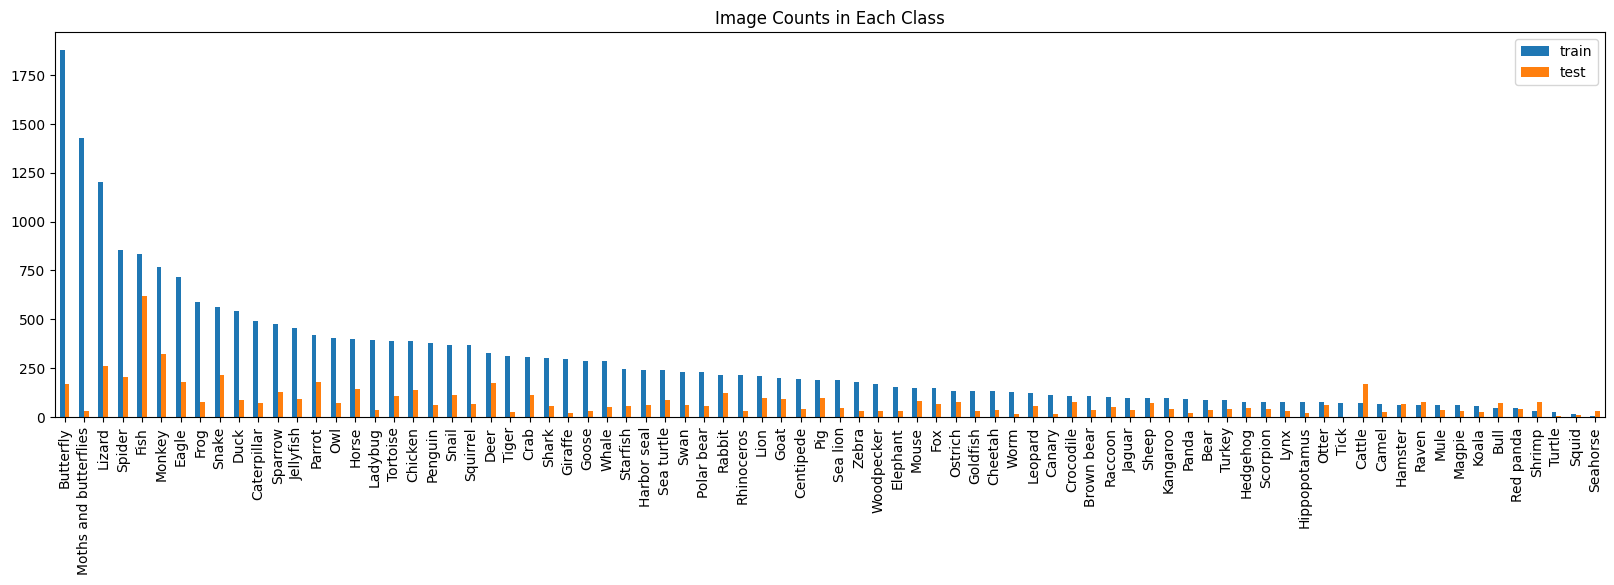

In [22]:
all_data_df=all_data_df.sort_values(by=["train","test"], ascending=False)
all_data_df.plot(kind="bar", legend=True, figsize=(20,5), title="Image Counts in Each Class");

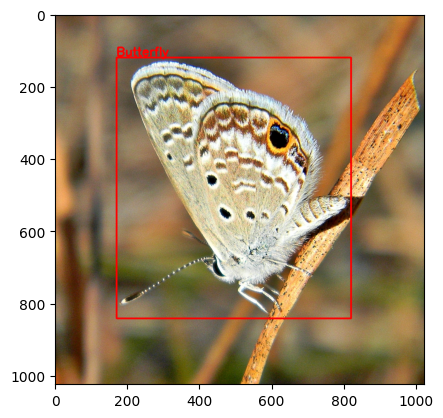

In [23]:
def draw_image(image_file, label_file, class_names):
    class_name = os.path.basename(os.path.dirname(image_file))    
    image = cv2.imread(image_file)
        
    with open(label_file) as fobj:
        while True:            
            item = fobj.readline()
            if item is None or len(item)<=0:
                break
                
            item = item[len(class_name):]
            item = item.split()
            xmin = float(item[0])
            ymin = float(item[1])
            xmax = float(item[2])
            ymax = float(item[3])
        
            image = cv2.rectangle(image, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0,0,255), 3)
            image = cv2.putText(image, class_name, (int(xmin), int(ymin-5)), cv2.FONT_HERSHEY_SIMPLEX, 1.1, (0, 0, 255), 3)
        
    return image

subdir = all_train_subdir[5]
image_files = glob.glob(os.path.join(subdir, "*.jpg"))

image_file = image_files[0]
label_file = os.path.join(subdir, "Label", os.path.basename(image_file).replace(".jpg", ".txt"))

image = draw_image(image_file, label_file, train_classes)
image = image[:,:,2::-1]
plt.imshow(image);

In [24]:
yolo_train_dir = "yolo/train"
yolo_test_dir = "yolo/test"

for dd in [yolo_train_dir, yolo_test_dir]:
    for ss in ["images", "labels"]:
        print(os.path.join(dd, ss))
        os.makedirs(os.path.join(dd, ss), exist_ok=True)

yolo/train/images
yolo/train/labels
yolo/test/images
yolo/test/labels


In [25]:
for subdir_id in tqdm(range(len(all_train_subdir))):
    subdir = all_train_subdir[subdir_id]

100%|██████████| 80/80 [00:00<00:00, 177068.24it/s]


In [27]:
def process_dataset(subdirs, dst_dir, class_names, size=(640,640), link=False):
    for subdir_id in tqdm(range(len(subdirs))):
        subdir = subdirs[subdir_id]
        prefix=os.path.basename(subdir)
        for image_file in glob.glob(os.path.join(subdir, "*.jpg")):
            image_file_basename=os.path.basename(image_file)
            label_file = os.path.join(subdir, "Label", image_file_basename).replace(".jpg", ".txt")
            dst_image_file = os.path.join(dst_dir, "images/%s_%s"%(prefix,image_file_basename))
            dst_label_file = os.path.join(dst_dir, "labels/%s_%s"%(prefix,image_file_basename.replace(".jpg", ".txt")))
            if os.path.exists(dst_label_file):
                continue
                        
            image = cv2.imread(image_file)                
            height, width = image.shape[0:2]
            with open(label_file) as fobj:
                with open(dst_label_file, "w") as wobj:
                    while True:
                        item = fobj.readline()
                        if item is None or len(item)==0:
                            break
                        class_name = prefix
                        item=item[len(class_name):]
                        item = item.split()
                        xmin = float(item[0])
                        ymin = float(item[1])
                        xmax = float(item[2])
                        ymax = float(item[3])

                        cx   = (xmin + xmax)/2.0/width
                        cy   = (ymin + ymax)/2.0/height
                        bw   = (xmax - xmin)/width
                        bh   = (ymax - ymin)/height
                        class_id = class_names.index(class_name)
                        output_line = "%d %f %f %f %f\n"%(class_id, cx, cy, bw, bh)
                        wobj.write(output_line)

            if link==True:
                os.symlink(image_file, dst_image_file)
            else:
                image = cv2.resize(image, size)
                cv2.imwrite(dst_image_file, image)

process_dataset(all_train_subdir, yolo_train_dir, train_classes, size=(640,640), link=False)          

100%|██████████| 80/80 [05:28<00:00,  4.10s/it]


In [31]:
for subdir_id in tqdm(range(len(all_test_subdir))):
    subdir = all_test_subdir[subdir_id]

100%|██████████| 80/80 [00:00<00:00, 104726.69it/s]


In [34]:
def process_dataset(subdirs, dst_dir, class_names, size=(640,640), link=False):
    for subdir_id in tqdm(range(len(subdirs))):
        subdir = subdirs[subdir_id]
        prefix=os.path.basename(subdir)
        for image_file in glob.glob(os.path.join(subdir, "*.jpg")):
            image_file_basename=os.path.basename(image_file)
            label_file = os.path.join(subdir, "Label", image_file_basename).replace(".jpg", ".txt")
            dst_image_file = os.path.join(dst_dir, "images/%s_%s"%(prefix,image_file_basename))
            dst_label_file = os.path.join(dst_dir, "labels/%s_%s"%(prefix,image_file_basename.replace(".jpg", ".txt")))
            if os.path.exists(dst_label_file):
                continue
                        
            image = cv2.imread(image_file)                
            height, width = image.shape[0:2]
            with open(label_file) as fobj:
                with open(dst_label_file, "w") as wobj:
                    while True:
                        item = fobj.readline()
                        if item is None or len(item)==0:
                            break
                        class_name = prefix
                        item=item[len(class_name):]
                        item = item.split()
                        xmin = float(item[0])
                        ymin = float(item[1])
                        xmax = float(item[2])
                        ymax = float(item[3])

                        cx   = (xmin + xmax)/2.0/width
                        cy   = (ymin + ymax)/2.0/height
                        bw   = (xmax - xmin)/width
                        bh   = (ymax - ymin)/height
                        class_id = class_names.index(class_name)
                        output_line = "%d %f %f %f %f\n"%(class_id, cx, cy, bw, bh)
                        wobj.write(output_line)

            if link==True:
                os.symlink(image_file, dst_image_file)
            else:
                image = cv2.resize(image, size)
                cv2.imwrite(dst_image_file, image)

process_dataset(all_test_subdir, yolo_test_dir, test_classes, size=(640,640), link=False)  

100%|██████████| 80/80 [01:42<00:00,  1.28s/it]


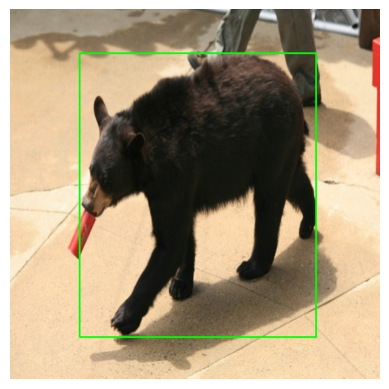

In [29]:
import cv2
import numpy as np

def get_image_dimensions(image_path):
    image = cv2.imread(image_path)
    height, width, _ = image.shape
    return width, height

# Image path
image_path = '/Users/dialvare/Desktop/yolo/train/images/Bear_0155b267ade95d1e.jpg'

# Get image dimensions
image_width, image_height = get_image_dimensions(image_path)

def read_labels(label_file_path):
    with open(label_file_path, 'r') as file:
        lines = file.readlines()
    bounding_boxes = []
    for line in lines:
        # Convert to YOLO (x_min, y_min, width, height)
        _, x_center, y_center, width, height = map(float, line.strip().split())
        x_min = int((x_center - width / 2) * image_width)
        y_min = int((y_center - height / 2) * image_height)
        bbox_width = int(width * image_width)
        bbox_height = int(height * image_height)
        bounding_boxes.append((x_min, y_min, bbox_width, bbox_height))
    return bounding_boxes

# Path to labels
label_file_path = '/Users/dialvare/Desktop/yolo/train/labels/Bear_0155b267ade95d1e.txt'

# Read labels
bbox = read_labels(label_file_path)

# Create bounding box 
def overlay_bbox(image, bbox, color=(0, 255, 0), thickness=2):
    x, y, w, h = bbox[0]
    cv2.rectangle(image, (x, y), (x + w, y + h), color, thickness)

# Load image
image = cv2.imread(image_path)

# Bounding box overlay
overlay_bbox(image, bbox)

# Show image with bounding box
cv2.imwrite('image_with_bbox.jpg', image)

# Read image with Matplotlib
image_with_bbox = plt.imread('image_with_bbox.jpg')

# Show image with Matplotlib
plt.imshow(image_with_bbox)
plt.axis('off')
plt.show()